In [13]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from collections import defaultdict
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter

In [14]:
class Vehicle:
    """Define vehicle attributes and rules to be implemented"""
    def __init__(self, x_position, speed, max_speed, length, width, road_designation, vehicle_type, current_row, lane_changing_prob, passenger_capacity):
        self.x_position = x_position #position along the length of the road (x position)
        self.speed = speed #number of cells the vehicle will move per timestep
        self.max_speed = max_speed #maximum speed
        self.braking_prob = 0.01 #probability of random slowdown
        self.length = length #length of the vehicle is the number of cells the vehicle occupies along the length of the road
        self.width = width #width of the vehicle is the number of cells the vehicle occupies along the width of the road
        self.road_designation = road_designation #whether inside or outside
        self.vehicle_type = vehicle_type #type of vehicle is determined by the size and behavior
        self.current_row = current_row #also known as the y position of the right side of the vehicle
        self.lane_changing_prob = lane_changing_prob #probability that a vehicle will transfer lane
        self.passenger_capacity = passenger_capacity
        self.occupied_seats = np.random.randint(0, passenger_capacity + 1)
        self.passengers = [Passenger(None, initially_on_vehicle=True) for _ in range(self.occupied_seats)]
        self.unoccupied_seats = self.passenger_capacity - self.occupied_seats
        
    def accelerate(self):
        """Increases vehicle's speed by 1 cell, up to the maximum speed"""
        if self.speed < self.max_speed:
            self.speed += 1

    def lane_changing(self, gap_distance):
        """attempts to change lanes based on vehicle type and lane availability
        Here, we define a lane as a space of 2 cells wide. We assume a two-lane road(4 cells wide, with 1 cell wide passenger holding area beside row 0).
        We assume that each half lane is an array, imagine a vertical stack of arrays, indexing is from top to bottom (0-4). Right side is the bottom."""
        new_row = self.current_row
        if self.speed > gap_distance:
            if self.current_row == 0:
                new_row = self.current_row + 2
            elif self.current_row == 2:
                new_row = self.current_row - 2
        #Check for space on the lane of interest
        if self.road_designation.road_occupancy[self.x_position:self.x_position + self.length, new_row:new_row + self.width].sum() == 0:
            self.current_row = new_row

    def decelerate(self, gap_distance):
        """decreases vehicle's speed to match the gap distance, given the speed>gap distance"""
        if self.speed > gap_distance:
            self.speed = gap_distance

    def braking(self):
        """Mimics random slowdown, randomly decreases vehicle's speed based on braking probability """
        if np.random.rand() < self.braking_prob and self.speed > 0:
            self.speed -= 1

    def move(self):
        """implements movement"""
        self.x_position = (self.x_position + self.speed) % self.road_designation.road_length

    def pick_up_passengers(self, passengers_at_sidewalk):
        """When jeep position on lane 0 is adjacent to an occupied position on the sidewalk, jeepney stops, then picks up all the passengers that it can pick up"""
        for passenger in passengers_at_sidewalk:
            if self.unoccupied_seats > 0:
                passenger.on_vehicle = True
                self.passengers.append(passenger)
                self.occupied_seats += 1
                self.unoccupied_seats -= 1

    def reset_occupancy(self):
        """This method resets occupancy when the vehicle reaches the end"""
        self.passengers = [Passenger(None, initially_on_vehicle=True) for _ in range(self.occupied_seats)]
        self.unoccupied_seats = self.passenger_capacity - self.occupied_seats

In [15]:
class Passenger:
    def __init__(self, location, initially_on_vehicle=False):
        self.location = location # sets initial location
        self.waiting_time = 0
        self.travel_time = 0
        self.on_vehicle = False #whether the passenger is on the vehicle or not
        self.initially_on_vehicle = False #whether the passenger is already on the vehicle or not

    def increment_waiting_time(self):
        """increments the waiting_time by 1 if the passenger is not on the vehicle."""
        if not self.on_vehicle:
            self.waiting_time += 1

    def increment_travel_time(self):
        """increments the travel time by 1 if the passenger is on the vehicle."""
        if self.on_vehicle:
            self.travel_time += 1

    def __repr__(self):
        """String representation of the passenger - for debugging """
        return f"Passenger(waiting_time={self.waiting_time}, travel_time={self.travel_time}, initially_on_vehicle={self.initially_on_vehicle})"

In [16]:
class Road:
    def __init__(self, road_length, road_width, speed_limit):
        self.road_length = road_length
        self.road_width = road_width
        self.speed_limit = speed_limit
        self.road_occupancy = np.zeros((road_length, road_width))

In [17]:
class Sidewalk:
    def __init__(self, sidewalk_length, passenger_spots_per_cell):
        self.sidewalk_length = sidewalk_length
        self.sidewalk_width = 1
        self.passenger_spots = passenger_spots_per_cell
        #initialize the sidewalk occupancy as a matrix of matrices
        self.sidewalk_occupancy = np.array([[np.full(passenger_spots_per_cell, None) for _ in range(self.sidewalk_width)] for _ in range(sidewalk_length)])
        
    def __repr__(self):
        return f"Sidewalk(occupancy={self.sidewalk_occupancy})"

In [18]:
class IntraRoadSimulator:
    def __init__(self, road):
        self.road = road  # Store the road instance
        self.vehicles = []  # List to store vehicle instances
        self.passengers = []  # List to store passenger instances
        self.sidewalk = Sidewalk(road.road_length, passenger_spots_per_cell = 10)
        self.occupancy_history = []  # List to store the history of road occupancy states
        self.passenger_throughput = 0  # Counter for the number of passengers transported
        self.vehicle_throughput = 0
        self.slowdown_counts = 0  # Counter for the number of slowdowns due to traffic

    def update_occupancy(self):
        self.road.road_occupancy.fill(0)
        for vehicle in self.vehicles:
            x_start = vehicle.x_position
            x_end = (vehicle.x_position + vehicle.length) % self.road.road_length
            y_start = vehicle.current_row
            y_end = min(vehicle.current_row + vehicle.width, self.road.road_width)
            if x_start < x_end:
                self.road.road_occupancy[x_start:x_end, y_start:y_end] = 1
            else:
                self.road.road_occupancy[x_start:, y_start:y_end] = 1
                self.road.road_occupancy[:x_end, y_start:y_end] = 1
        self.occupancy_history.append(self.road.road_occupancy.copy)

    def initialize_vehicles(self, density, truck_fraction, truck_lane_change_prob, jeep_lane_change_prob):
        A, B = 7 * 2, 3 * 2  # Constants for truck and jeep area
        L, W = self.road.road_length, self.road.road_width  # Road dimensions
        N = int(density * L * W * (truck_fraction / A + (1 - truck_fraction) / B))  # Number of vehicles based on density and truck fraction
        for _ in range(N):
            vehicle_type = 'truck' if np.random.rand() < truck_fraction else 'jeep'  # Randomly decide vehicle type
            length = 7 if vehicle_type == 'truck' else 3
            width = 2
            x_position = np.random.randint(0, self.road.road_length)  # Random initial position
            speed = np.random.randint(1, self.road.speed_limit + 1)
            passenger_capacity = 20 if vehicle_type == 'jeep' else 0
            lane_changing_prob = truck_lane_change_prob if vehicle_type == 'truck' else jeep_lane_change_prob
            current_row = 2 if vehicle_type == 'truck' else 0
            if self.road.road_occupancy[x_position:x_position + length, current_row:current_row + width].sum() == 0:
                new_vehicle = Vehicle(x_position, speed, self.road.speed_limit, length, width, self.road, vehicle_type, current_row, lane_changing_prob, passenger_capacity)
                self.vehicles.append(new_vehicle)  # Add vehicle to the list
                self.road.road_occupancy[x_position:x_position + length, current_row:current_row + width] = 1  # Mark vehicle position on road occupancy grid

    def gap_distance(self, vehicle, vehicle_lane_to_be_checked):
        current_x_position = vehicle.x_position
        max_distance = min(vehicle.speed, self.road.road_length - current_x_position - vehicle.length)  # Maximum possible gap distance
        lane_row_1 = vehicle_lane_to_be_checked
        lane_row_2 = lane_row_1 + 1
        gap_distance_row_1 = max_distance
        gap_distance_row_2 = max_distance
        for distance in range(1, max_distance + 1):
            next_x_position = current_x_position + vehicle.length + distance
            if next_x_position >= self.road.road_length or self.road.road_occupancy[next_x_position, vehicle.current_row] == 1:
                gap_distance_row_1 = distance - 1  # Calculate gap distance in current lane
                break
        for distance in range(1, max_distance + 1):
            next_x_position = current_x_position + vehicle.length + distance
            if next_x_position >= self.road.road_length or self.road.road_occupancy[next_x_position, vehicle.current_row] == 1:
                gap_distance_row_2 = distance - 1  # Calculate gap distance in adjacent lane
                break
        return min(gap_distance_row_1, gap_distance_row_2)  # Return the minimum gap distance

    def passenger_arrival(self, arrival_rate):
        for x in range(self.road.road_length):
            if np.random.rand() < arrival_rate:  # Determine if a passenger arrives at this location
                for i in range(self.sidewalk.passenger_spots):
                    if self.sidewalk.sidewalk_occupancy[x][0][i] is None:  # Find an empty spot on the sidewalk
                        new_passenger = Passenger(location=(x, 0))
                        self.sidewalk.sidewalk_occupancy[x][0][i] = new_passenger  # Place the new passenger on the sidewalk
                        self.passengers.append(new_passenger)  # Add the new passenger to the list
                        break
                        
    def record_throughput(self, vehicle):
        self.passenger_throughput += vehicle.occupied_seats  # Add the number of occupied seats to the passenger throughput count
        self.vehicle_throughput += 1
    
    def reset_vehicle(self, vehicle):
        self.record_throughput(vehicle)  # Record the throughput of the vehicle
        for passenger in vehicle.passengers:
            passenger.on_vehicle = False  # Set passengers to not on vehicle
        vehicle.passengers = [Passenger(None, initially_on_vehicle=True) for _ in range(vehicle.occupied_seats)]  # Reset passengers
        vehicle.unoccupied_seats = vehicle.passenger_capacity - vehicle.occupied_seats  # Reset unoccupied seats

    def simulation_step(self, density, truck_fraction, arrival_rate):
        self.passenger_arrival(arrival_rate)  # Simulate passenger arrival
        
        for passenger in self.passengers:
            passenger.increment_waiting_time()  # Increment waiting time for each passenger
        
        for vehicle in self.vehicles:
            gap_distance_of_own_lane = self.gap_distance(vehicle, vehicle.current_row)  # Calculate gap distance in current lane
            vehicle.accelerate()  # Accelerate the vehicle
            
            if vehicle.speed > gap_distance_of_own_lane:
                other_lane = 2 if vehicle.current_row == 0 else 0  # Determine other lane
                gap_distance_of_other_lane = self.gap_distance(vehicle, other_lane)  # Calculate gap distance in other lane
                if gap_distance_of_other_lane > gap_distance_of_own_lane:
                    if np.random.rand() < vehicle.lane_changing_prob:
                        vehicle.lane_changing(gap_distance_of_other_lane)  # Change lane if possible
                        vehicle.decelerate(gap_distance_of_own_lane)  # Decelerate if necessary
                    else:
                        vehicle.decelerate(gap_distance_of_own_lane)  # Decelerate if not changing lanes
                        vehicle.braking()  # Apply brakes
                        self.slowdown_counts += 1  # Increment slowdown count
                        
            if vehicle.vehicle_type == 'jeep':
                sidewalk_x_position = (vehicle.x_position + vehicle.length // 2) % self.road.road_length
                passengers_at_stop = [p for p in self.sidewalk.sidewalk_occupancy[sidewalk_x_position][0] if p is not None and not p.on_vehicle]
                
                if passengers_at_stop and vehicle.unoccupied_seats > 0:
                    vehicle.decelerate(0)  # Decelerate to pick up passengers
                    vehicle.pick_up_passengers(passengers_at_stop)  # Pick up passengers
                    
            if vehicle.x_position + vehicle.speed >= self.road.road_length - vehicle.length:
                vehicle.speed = 0  # Stop the vehicle if it reaches the end of the road
                self.reset_vehicle(vehicle)  # Reset the vehicle
                
            for passenger in vehicle.passengers:
                passenger.increment_travel_time()  # Increment travel time for each passenger
                
            vehicle.move()  # Move the vehicle
            
        self.update_occupancy()  # Update the road occupancy grid

    def animate(self, num_steps, interval=100):
        """Animate the road occupancy over time and save as GIF or MP4"""
        fig, ax = plt.subplots(figsize=(20, 6))
        
        def update(frame):
            self.simulation_step(density=0.2, truck_fraction=0.5, arrival_rate=0.5)
            ax.clear()
            ax.imshow(self.road.road_occupancy.T, cmap='gray_r', origin='lower')
            ax.set_title(f'Step {frame}')
            ax.set_xlabel('Road Length')
            ax.set_ylabel('Lane')
            ax.set_xticks(range(0, self.road.road_length + 1, 1))
            ax.set_yticks(range(0, self.road.road_width + 1, 1))
            ax.set_ylim(-0.5, 3.5)  # Ensure y-limits stay consistent
            
        ani = FuncAnimation(fig, update, frames=num_steps, interval=interval)
        # Save the animation
        ani.save("simulation_animation.gif", writer=PillowWriter(fps=10))
        #ani.save("simulation_animation.mp4", writer=FFMpegWriter(fps=10))
        plt.close(fig)

    def spatio_temporal_plot(self):
        """Create a spatio-temporal plot for each lane"""
        fig, axes = plt.subplots(2, 1, figsize=(20, 12))
        
        for lane in range(2):
            spatio_temporal_data = np.array([occupancy[:, lane*2:(lane+1)*2].sum(axis=1) for occupancy in self.occupancy_history])
            axes[lane].imshow(spatio_temporal_data, cmap='gray_r', aspect='auto', origin='lower')
            axes[lane].set_title(f'Spatio-Temporal Plot for Lane {lane + 1}')
            axes[lane].set_xlabel('Position')
            axes[lane].set_ylabel('Timestep')
            axes[lane].set_xlim(0, self.road.road_length)
            axes[lane].set_ylim(0, len(self.occupancy_history))

        plt.tight_layout()
        plt.show()

    def print_passenger_times(self):
        for i, passenger in enumerate(self.passengers):
            print(f"Passenger {i}: Waiting Time = {passenger.waiting_time}, Travel Time = {passenger.travel_time}, Initially on Vehicle = {passenger.initially_on_vehicle}")

TypeError: 'builtin_function_or_method' object is not subscriptable

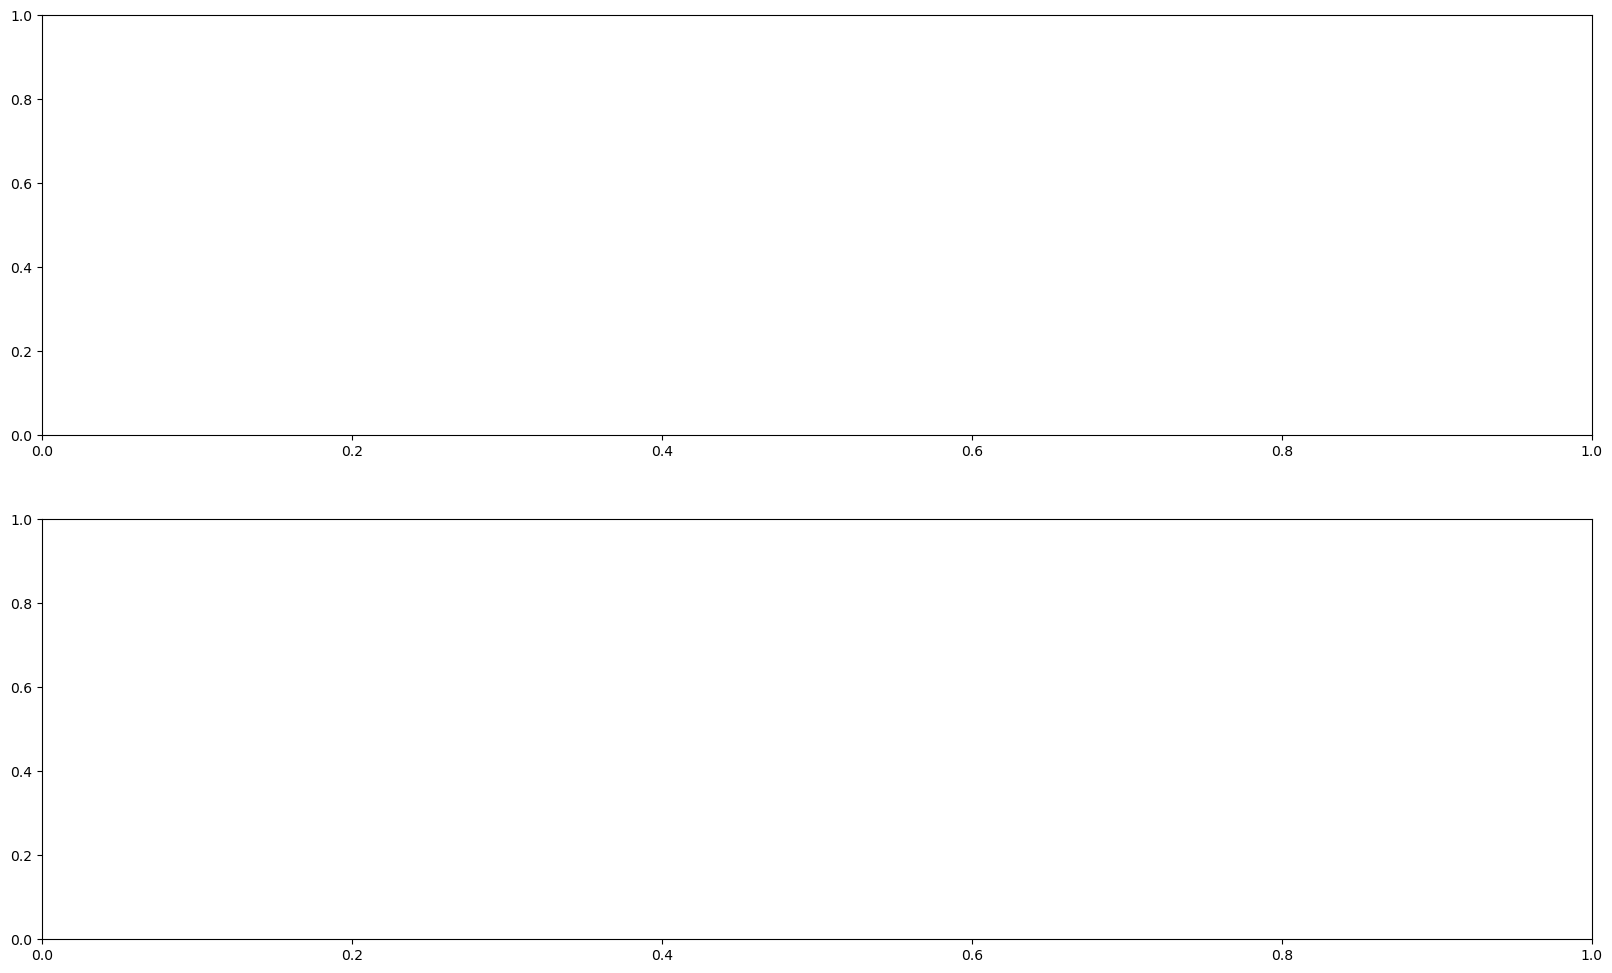

In [19]:
# Example Usage
road = Road(road_length=100, road_width=4, speed_limit=5)
simulator = IntraRoadSimulator(road)


simulator.initialize_vehicles(density=0.2, truck_fraction=0.5, truck_lane_change_prob=0.1, jeep_lane_change_prob=0.2)

# Running the animation and saving it
simulator.animate(num_steps=100, interval=100)

# Creating spatio-temporal plots
simulator.spatio_temporal_plot()

The following is another tester.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from collections import defaultdict

class Vehicle:
    def __init__(self, x_position, speed, max_speed, length, width, road_designation, vehicle_type, current_row, lane_changing_prob, passenger_capacity):
        self.x_position = x_position
        self.speed = speed
        self.max_speed = max_speed
        self.braking_prob = 0.01
        self.length = length
        self.width = width
        self.road_designation = road_designation
        self.vehicle_type = vehicle_type
        self.current_row = current_row
        self.lane_changing_prob = lane_changing_prob
        self.passenger_capacity = passenger_capacity
        self.occupied_seats = np.random.randint(0, passenger_capacity + 1)
        self.passengers = [Passenger(None, initially_on_vehicle=True) for _ in range(self.occupied_seats)]
        self.unoccupied_seats = self.passenger_capacity - self.occupied_seats

    def accelerate(self):
        if self.speed < self.max_speed:
            self.speed += 1

    def lane_changing(self, gap_distance):
        new_row = self.current_row
        if self.speed > gap_distance:
            if self.current_row == 0:
                new_row = self.current_row + 2
            elif self.current_row == 2:
                new_row = self.current_row - 2
        if self.road_designation.road_occupancy[self.x_position:self.x_position + self.length, new_row:new_row + self.width].sum() == 0:
            self.current_row = new_row

    def decelerate(self, gap_distance):
        if self.speed > gap_distance:
            self.speed = gap_distance

    def braking(self):
        if np.random.rand() < self.braking_prob and self.speed > 0:
            self.speed -= 1

    def move(self):
        self.x_position = (self.x_position + self.speed) % self.road_designation.road_length

    def pick_up_passengers(self, passengers_at_sidewalk):
        for passenger in passengers_at_sidewalk:
            if self.unoccupied_seats > 0:
                passenger.on_vehicle = True
                passenger.location = None
                self.passengers.append(passenger)
                self.occupied_seats += 1
                self.unoccupied_seats -= 1

    def reset_occupancy(self):
        self.passengers = [Passenger(None, initially_on_vehicle=True) for _ in range(self.occupied_seats)]
        self.unoccupied_seats = self.passenger_capacity - self.occupied_seats

class Passenger:
    def __init__(self, location, initially_on_vehicle=False):
        self.location = location
        self.waiting_time = 0
        self.travel_time = 0
        self.on_vehicle = False
        self.initially_on_vehicle = initially_on_vehicle

    def increment_waiting_time(self):
        if not self.on_vehicle:
            self.waiting_time += 1

    def increment_travel_time(self):
        if self.on_vehicle:
            self.travel_time += 1

    def __repr__(self):
        return f"Passenger(waiting_time={self.waiting_time}, travel_time={self.travel_time}, initially_on_vehicle={self.initially_on_vehicle})"

class Road:
    def __init__(self, road_length, road_width, speed_limit):
        self.road_length = road_length
        self.road_width = road_width
        self.speed_limit = speed_limit
        self.road_occupancy = np.zeros((road_length, road_width))

class IntraRoadSimulator:
    def __init__(self, road):
        self.road = road
        self.vehicles = []
        self.passengers = []
        self.sidewalk = np.zeros((road.road_length, 10), dtype=object)
        for i in range(road.road_length):
            self.sidewalk[i] = [None] * 10
        self.occupancy_history = []
        self.passenger_throughput = 0
        self.slowdown_counts = 0

    def update_occupancy(self):
        self.road.road_occupancy.fill(0)
        for vehicle in self.vehicles:
            x_start = vehicle.x_position
            x_end = (vehicle.x_position + vehicle.length) % self.road.road_length
            y_start = vehicle.current_row
            y_end = min(vehicle.current_row + vehicle.width, self.road.road_width)
            if x_start < x_end:
                self.road.road_occupancy[x_start:x_end, y_start:y_end] = 1
            else:
                self.road.road_occupancy[x_start:, y_start:y_end] = 1
                self.road.road_occupancy[:x_end, y_start:y_end] = 1
        self.occupancy_history.append(self.road.road_occupancy.copy())

    def initialize_vehicles(self, density, truck_fraction):
        A, B = 7 * 2, 3 * 2
        L, W = self.road.road_length, self.road.road_width
        N = int(density * L * W * (truck_fraction / A + (1 - truck_fraction) / B))
        for _ in range(N):
            vehicle_type = 'truck' if np.random.rand() < truck_fraction else 'jeep'
            length = 7 if vehicle_type == 'truck' else 3
            width = 2
            x_position = np.random.randint(0, self.road.road_length)
            speed = np.random.randint(1, self.road.speed_limit + 1)
            passenger_capacity = 20 if vehicle_type == 'jeep' else 0
            lane_changing_prob = 0.5 if vehicle_type == 'truck' else 0
            current_row = 2 if vehicle_type == 'truck' else 0
            if self.road.road_occupancy[x_position:x_position + length, current_row:current_row + width].sum() == 0:
                new_vehicle = Vehicle(x_position, speed, self.road.speed_limit, length, width, self.road, vehicle_type, current_row, lane_changing_prob, passenger_capacity)
                self.vehicles.append(new_vehicle)
                self.road.road_occupancy[x_position:x_position + length, current_row:current_row + width] = 1

    def gap_distance(self, vehicle, vehicle_lane_to_be_checked):
        current_x_position = vehicle.x_position
        max_distance = min(vehicle.speed, self.road.road_length - current_x_position - vehicle.length)
        lane_row_1 = vehicle_lane_to_be_checked
        lane_row_2 = lane_row_1 + 1
        gap_distance_row_1 = max_distance
        gap_distance_row_2 = max_distance
        for distance in range(1, max_distance + 1):
            next_x_position = current_x_position + vehicle.length + distance
            if next_x_position >= self.road.road_length or self.road.road_occupancy[next_x_position, vehicle.current_row] == 1:
                gap_distance_row_1 = distance - 1
                break
        for distance in range(1, max_distance + 1):
            next_x_position = current_x_position + vehicle.length + distance
            if next_x_position >= self.road.road_length or self.road.road_occupancy[next_x_position, vehicle.current_row] == 1:
                gap_distance_row_2 = distance - 1
                break
        return min(gap_distance_row_1, gap_distance_row_2)

    def passenger_arrival(self, arrival_rate):
        for x in range(self.road.road_length):
            if np.random.rand() < arrival_rate:
                for i in range(10):
                    if self.sidewalk[x][i] is None:
                        new_passenger = Passenger(location=(x, 0))
                        self.sidewalk[x][i] = new_passenger
                        self.passengers.append(new_passenger)
                        break

    def record_throughput(self, vehicle):
        self.passenger_throughput += vehicle.occupied_seats

    def reset_vehicle(self, vehicle):
        self.record_throughput(vehicle)
        for passenger in vehicle.passengers:
            passenger.on_vehicle = False
        vehicle.passengers = [Passenger(None, initially_on_vehicle=True) for _ in range(vehicle.occupied_seats)]
        vehicle.unoccupied_seats = vehicle.passenger_capacity - vehicle.occupied_seats

    def simulation_step(self, density, truck_fraction, arrival_rate):
        self.initialize_vehicles(density, truck_fraction)
        self.passenger_arrival(arrival_rate)
        for passenger in self.passengers:
            passenger.increment_waiting_time()
        for vehicle in self.vehicles:
            gap_distance_of_own_lane = self.gap_distance(vehicle, vehicle.current_row)
            vehicle.accelerate()
            if vehicle.speed > gap_distance_of_own_lane:
                other_lane = 2 if vehicle.current_row == 0 else 0
                gap_distance_of_other_lane = self.gap_distance(vehicle, other_lane)
                if gap_distance_of_other_lane > gap_distance_of_own_lane:
                    if np.random.rand() < vehicle.lane_changing_prob:
                        vehicle.lane_changing(gap_distance_of_other_lane)
                        vehicle.decelerate(gap_distance_of_own_lane)
                    else:
                        vehicle.decelerate(gap_distance_of_own_lane)
                        vehicle.braking()
                        self.slowdown_counts += 1
            if vehicle.vehicle_type == 'jeep':
                sidewalk_x_position = (vehicle.x_position + vehicle.length // 2) % self.road.road_length
                passengers_at_stop = [p for p in self.sidewalk[sidewalk_x_position] if p is not None and not p.on_vehicle]
                if passengers_at_stop and vehicle.unoccupied_seats > 0:
                    vehicle.decelerate(0)
                    vehicle.pick_up_passengers(passengers_at_stop)
            if vehicle.x_position + vehicle.speed >= self.road.road_length - vehicle.length:
                vehicle.speed = 0
                self.reset_vehicle(vehicle)
            for passenger in vehicle.passengers:
                passenger.increment_travel_time()
            vehicle.move()
        self.update_occupancy()

    def visualize(self, step_count):
        plt.figure(figsize=(20, 6))
        plt.imshow(self.road.road_occupancy.T, cmap='gray_r', origin='lower')
        plt.title(f'Step {step_count}')
        plt.xlabel('Road Length')
        plt.ylabel('Lane')
        plt.xticks(range(0, self.road.road_length + 1, 1))
        plt.yticks(range(0, self.road.road_width + 1, 1))
        plt.tight_layout()
        plt.show()

    def print_passenger_times(self):
        for i, passenger in enumerate(self.passengers):
            print(f"Passenger {i}: Waiting Time = {passenger.waiting_time}, Travel Time = {passenger.travel_time}, Initially on Vehicle = {passenger.initially_on_vehicle}")

road = Road(road_length=100, road_width=4, speed_limit=5)
simulator = IntraRoadSimulator(road)

# Parameters
densities = np.linspace(0, 1, 11)
truck_ratios = [0.1, 0.2, 0.3]
lane_changing_probs = [0, 0.3, 0.5]
arrival_rate = 0.05
num_steps = 100

# Data storage
throughput_data = []
waiting_times_data = defaultdict(list)
travel_times_data = defaultdict(list)
slowdown_counts_data = []

for density in densities:
    for truck_ratio in truck_ratios:
        for lane_changing_prob in lane_changing_probs:
            road = Road(road_length=100, road_width=4, speed_limit=5)
            simulator = IntraRoadSimulator(road)
            for step in range(num_steps):
                simulator.simulation_step(density, truck_ratio, arrival_rate)
            throughput_data.append([density, truck_ratio, lane_changing_prob, simulator.passenger_throughput])
            slowdown_counts_data.append([density, truck_ratio, lane_changing_prob, simulator.slowdown_counts])
            for passenger in simulator.passengers:
                waiting_times_data[density].append(passenger.waiting_time)
                travel_times_data[density].append(passenger.travel_time)

# Save data to CSV
with open('throughput_data.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Density', 'Truck Ratio', 'Lane Changing Probability', 'Passenger Throughput'])
    writer.writerows(throughput_data)

with open('waiting_times_data.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Density', 'Waiting Time', 'Frequency'])
    for density, times in waiting_times_data.items():
        for time, freq in zip(*np.unique(times, return_counts=True)):
            writer.writerow([density, time, freq])

with open('travel_times_data.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Density', 'Travel Time', 'Frequency'])
    for density, times in travel_times_data.items():
        for time, freq in zip(*np.unique(times, return_counts=True)):
            writer.writerow([density, time, freq])

with open('slowdown_counts_data.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Density', 'Truck Ratio', 'Lane Changing Probability', 'Slowdown Counts'])
    writer.writerows(slowdown_counts_data)

print("Simulation complete. Data saved to CSV files.")

Simulation complete. Data saved to CSV files.


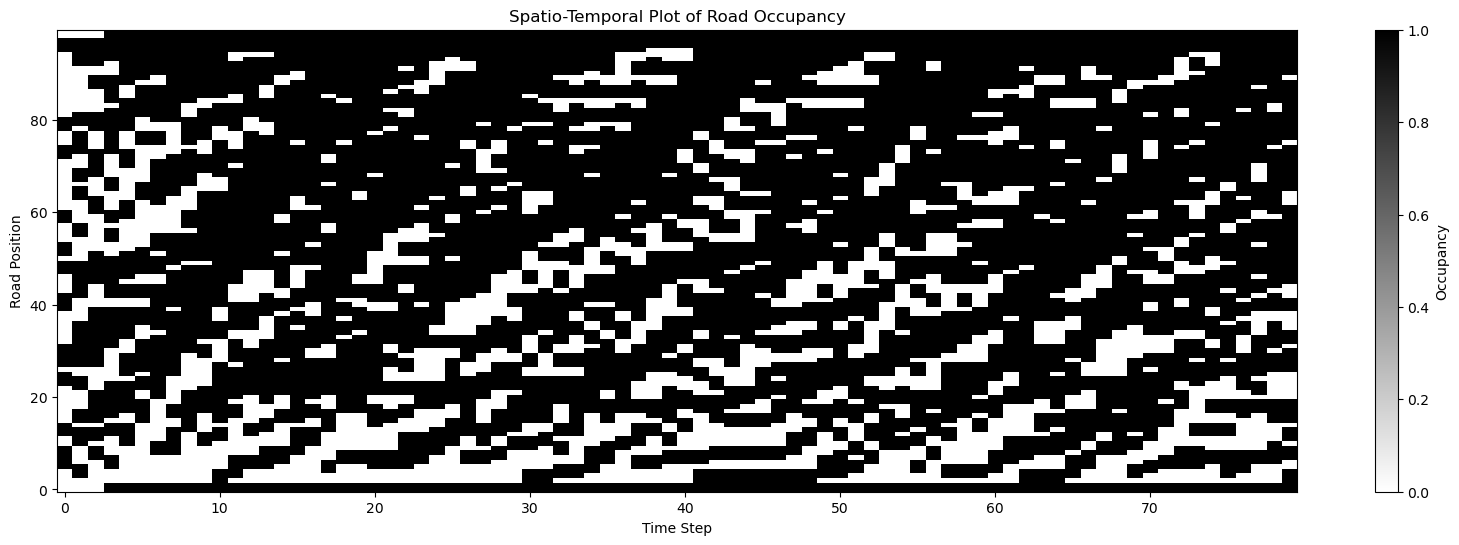

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to visualize the spatio-temporal plot of road occupancy
def plot_spatio_temporal_road(occupancy_history, road_length, num_steps):
    fig, ax = plt.subplots(figsize=(20, 6))
    road_occupancy_plot = np.array(occupancy_history).reshape((num_steps, road_length, -1))[:, :, 0]
    cax = ax.imshow(road_occupancy_plot, cmap='gray_r', origin='lower', aspect='auto')
    ax.set_title('Spatio-Temporal Plot of Road Occupancy')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Road Position')
    fig.colorbar(cax, ax=ax, label='Occupancy')
    plt.show()

# Example usage
road_length = 100
num_steps = 80

# Simulate and collect occupancy history
road = Road(road_length=road_length, road_width=4, speed_limit=5)
simulator = IntraRoadSimulator(road)

for step in range(num_steps):
    simulator.simulation_step(0.5, 0.2, 0.05)  # Example parameters

plot_spatio_temporal_road(simulator.occupancy_history, road_length, num_steps)